In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader
from smalldiffusion import TreeDataset, training_loop, samples, ScheduleLogLinear, ConditionalMLP

def plot_batch(batch, ax=None, **kwargs):
    batch = batch.cpu().numpy()
    ax = ax or plt
    return ax.scatter(batch[:,0], batch[:,1], marker='.', **kwargs)
    
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w    

%load_ext autoreload
%autoreload 2

# Define and plot tree dataset
Using a different color for each class. A class contains points from the root to a particular leaf.

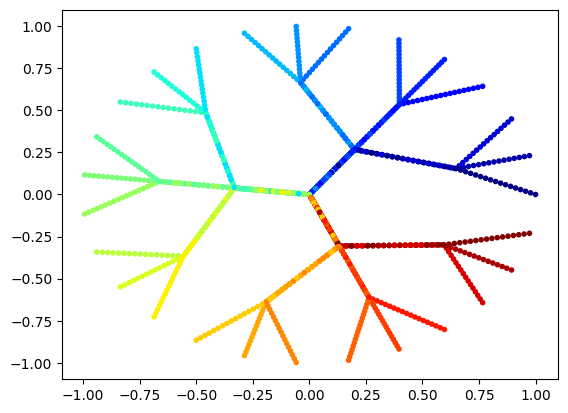

In [2]:
dataset = TreeDataset(branching_factor=3, depth=3, num_samples_per_path=50)
loader = DataLoader(dataset, batch_size=len(dataset)*2, shuffle=True)
x, labels = next(iter(loader))
plot_batch(x, c=labels, cmap='jet')
plt.show()

# Train conditional diffusion model

In [ ]:
model = ConditionalMLP(dim=2, hidden_dims=(16, 128, 256, 128, 16), cond_dim=4, num_classes=dataset.total_leaves)
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=10)
trainer = training_loop(loader, model, schedule, epochs=30000, lr=1e-3, conditional=True)
losses = [ns.loss.item() for ns in trainer]

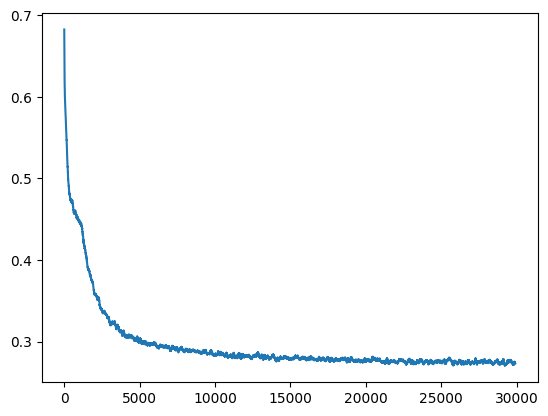

In [4]:
plt.plot(moving_average(losses, 100))
plt.show()

# Sample from conditional model using Classifier-Free Guidance

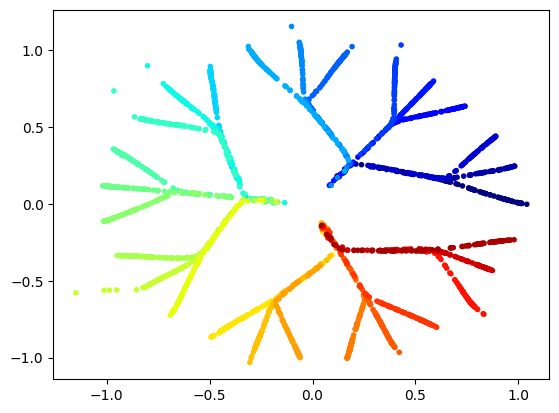

In [5]:
def sample_and_plot(model, schedule, num_classes, ax=None,
                    N_sample=20, sample_batch_size=100,
                    gam=1.5, cfg_scale=1.0, mu=0.0):
    for c in range(num_classes):
        *_, x0 = samples(
            model, schedule.sample_sigmas(N_sample),
            batchsize=sample_batch_size, gam=gam, mu=mu, cfg_scale=cfg_scale,
            cond=torch.tensor([c for _ in range(sample_batch_size)])
        )
        plot_batch(x0, ax=ax, c=[c]*sample_batch_size, cmap='jet', vmin=0, vmax=num_classes)

sample_and_plot(model, schedule, dataset.total_leaves)

# Varying CFG scale pushes samples towards leaves

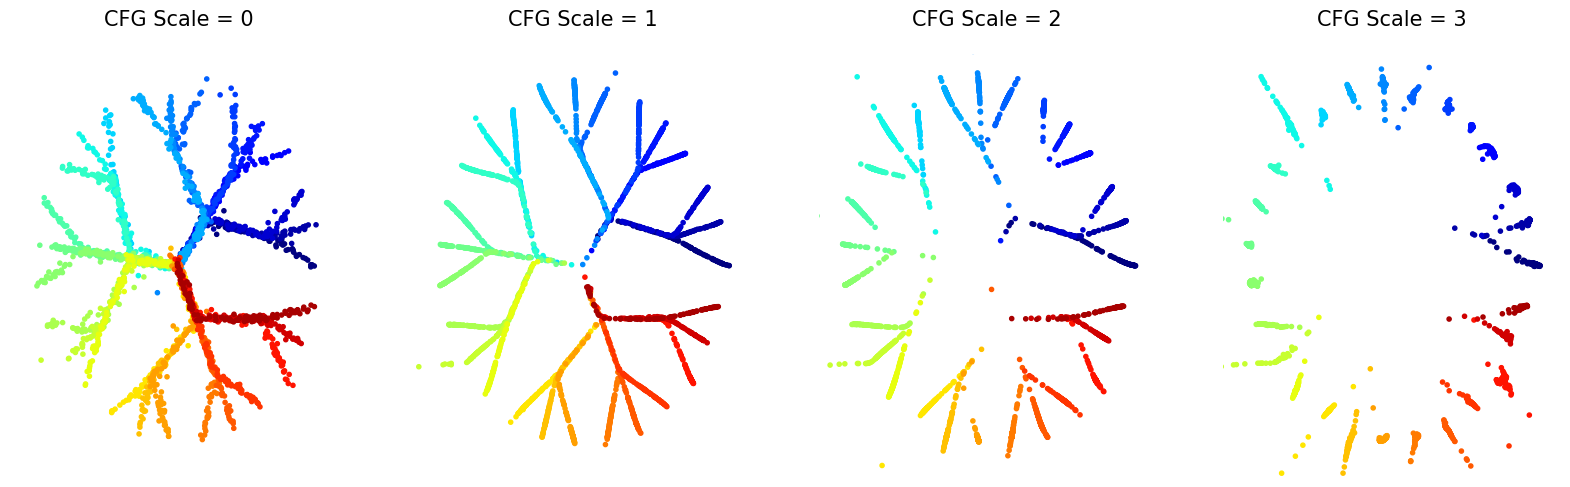

In [7]:
lim = 1.2
fig, axs = plt.subplots(1, 4, figsize=(20,5.5))
cfg_scales = [0, 1, 2, 3]

for ax, cfg_scale in zip(axs, cfg_scales):    
    ax.set_ylim((-lim,lim))
    ax.set_xlim((-lim,lim))
    sample_and_plot(model, schedule, dataset.total_leaves, ax=ax, cfg_scale=cfg_scale)
    ax.axis('off')
    ax.set_title(f'CFG Scale = {cfg_scale}', fontsize=15, pad=20)